# IDD Demo

In [1]:
from datetime import date
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import logit

from vaxflux.covariates import CovariateCategories, GaussianCovariate, PooledCovariate
from vaxflux.curves import LogisticCurve
from vaxflux.data import (
    get_ncird_weekly_cumulative_vaccination_coverage,
    sample_dataset,
)
from vaxflux.dates import SeasonRange, daily_date_ranges
from vaxflux.uptake import SeasonalUptakeModel

## Simple Demo With Synthetic Data

In [2]:
logistic_curve = LogisticCurve()
logistic_curve.parameters

('m', 'r', 's')

In [3]:
seasons = [
    SeasonRange(season="2022/23", start_date="2022-10-03", end_date="2023-02-05"),
    SeasonRange(season="2023/24", start_date="2023-10-02", end_date="2024-02-04"),
    SeasonRange(season="2024/25", start_date="2024-10-07", end_date="2025-02-02"),
    SeasonRange(season="2025/26", start_date="2025-10-06", end_date="2026-02-01"),
]
dates = daily_date_ranges(seasons, range_days=6)

In [4]:
parameters = [
    ("m", "2022/23", 0.50),
    ("r", "2022/23", -2.50),
    ("s", "2022/23", 40.00),
    ("m", "2023/24", 0.51),
    ("r", "2023/24", -2.40),
    ("s", "2023/24", 42.00),
    ("m", "2024/25", 0.52),
    ("r", "2024/25", -2.30),
    ("s", "2024/25", 44.00),
]
sample_observations = sample_dataset(
    logistic_curve,
    seasons[:-1],
    [d for d in dates if d.season != "2025/26"],
    [],
    parameters,
    0.0005,
    random_seed=123,
)
sample_observations.head(n=10)

,season,season_start_date,season_end_date,start_date,end_date,report_date,type,value
0,2022/23,2022-10-03,2023-02-05,2022-10-03,2022-10-09,2022-10-09,incidence,0.017104
1,2022/23,2022-10-03,2023-02-05,2022-10-10,2022-10-16,2022-10-16,incidence,0.028909
2,2022/23,2022-10-03,2023-02-05,2022-10-17,2022-10-23,2022-10-23,incidence,0.043948
3,2022/23,2022-10-03,2023-02-05,2022-10-24,2022-10-30,2022-10-30,incidence,0.062417
4,2022/23,2022-10-03,2023-02-05,2022-10-31,2022-11-06,2022-11-06,incidence,0.077870
5,2022/23,2022-10-03,2023-02-05,2022-11-07,2022-11-13,2022-11-13,incidence,0.090025
6,2022/23,2022-10-03,2023-02-05,2022-11-14,2022-11-20,2022-11-20,incidence,0.085255
7,2022/23,2022-10-03,2023-02-05,2022-11-21,2022-11-27,2022-11-27,incidence,0.070154
8,2022/23,2022-10-03,2023-02-05,2022-11-28,2022-12-04,2022-12-04,incidence,0.049434
9,2022/23,2022-10-03,2023-02-05,2022-12-05,2022-12-11,2022-12-11,incidence,0.035302


In [5]:
plot_observations = (
    sample_observations[["season", "end_date", "value"]]
    .rename(columns={"value": "incidence"})
    .sort_values(["season", "end_date"])
    .reset_index(drop=True)
)
plot_observations_recombine = []
for season, season_observations in plot_observations.groupby("season"):
    if year_shift := {"2022/23": 2, "2023/24": 1}.get(season):
        season_observations["end_date"] = season_observations[
            "end_date"
        ] + pd.DateOffset(years=year_shift)
    season_observations["prevalence"] = season_observations["incidence"].cumsum()
    plot_observations_recombine.append(season_observations)
plot_observations = pd.concat(plot_observations_recombine, ignore_index=True)
plot_observations.head(n=10)

,season,end_date,incidence,prevalence
0,2022/23,2024-10-09,0.017104,0.017104
1,2022/23,2024-10-16,0.028909,0.046012
2,2022/23,2024-10-23,0.043948,0.089960
3,2022/23,2024-10-30,0.062417,0.152376
4,2022/23,2024-11-06,0.077870,0.230247
5,2022/23,2024-11-13,0.090025,0.320272
6,2022/23,2024-11-20,0.085255,0.405527
7,2022/23,2024-11-27,0.070154,0.475682
8,2022/23,2024-12-04,0.049434,0.525115
9,2022/23,2024-12-11,0.035302,0.560417


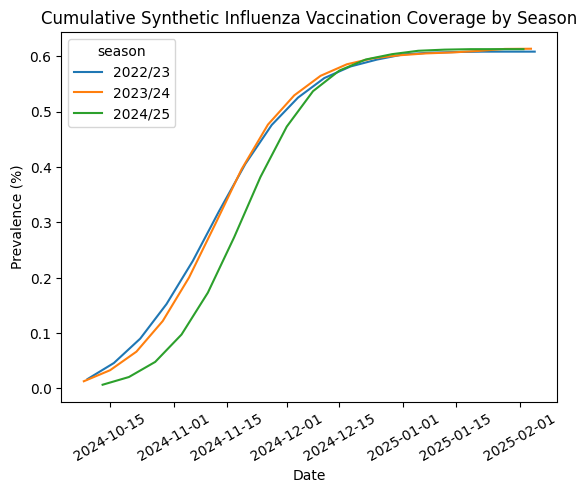

In [6]:
sns.lineplot(
    data=plot_observations,
    x="end_date",
    y="prevalence",
    hue="season",
)
plt.xlabel("Date")
plt.ylabel("Prevalence (%)")
plt.title("Cumulative Synthetic Influenza Vaccination Coverage by Season")
plt.xticks(rotation=30)
plt.show()

In [7]:
covariates = [
    PooledCovariate(
        parameter="m",
        covariate=None,
        distribution="Normal",
        distribution_kwargs={
            "mu": 0.5,
            "sigma": 0.15,
        },
    ),
    PooledCovariate(
        parameter="r",
        covariate=None,
        distribution="Normal",
        distribution_kwargs={
            "mu": -2.5,
            "sigma": 0.15,
        },
    ),
    PooledCovariate(
        parameter="s",
        covariate=None,
        distribution="Normal",
        distribution_kwargs={
            "mu": 40.0,
            "sigma": 5.0,
        },
    ),
]
covariates

[PooledCovariate(parameter='m', covariate=None, distribution='Normal', distribution_kwargs={'mu': 0.5, 'sigma': 0.15}),
 PooledCovariate(parameter='r', covariate=None, distribution='Normal', distribution_kwargs={'mu': -2.5, 'sigma': 0.15}),
 PooledCovariate(parameter='s', covariate=None, distribution='Normal', distribution_kwargs={'mu': 40.0, 'sigma': 5.0})]

In [8]:
model = SeasonalUptakeModel(
    logistic_curve,
    covariates,
    observations=sample_observations,
    season_ranges=seasons,
    date_ranges=dates,
    pooled_epsilon=True,
    epsilon=0.001,
)
model.build()

In [9]:
model.sample(tune=4_000, draws=1_000, chains=2, random_seed=123)

Running window adaptation


There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [10]:
posterior = model.dataframe()
posterior.info()

<class 'pandas.core.frame.DataFrame'>
Index: 980000 entries, 0 to 237999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   draw    980000 non-null  int64         
 1   chain   980000 non-null  int64         
 2   season  980000 non-null  string        
 3   date    980000 non-null  datetime64[ns]
 4   type    980000 non-null  string        
 5   value   980000 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(2)
memory usage: 52.3 MB


In [11]:
posterior = (
    posterior[["draw", "chain", "season", "date", "value"]]
    .rename(columns={"value": "incidence"})
    .sort_values(["draw", "chain", "season", "date"])
    .reset_index(drop=True)
)
posterior["prevalence"] = posterior.groupby(["draw", "chain", "season"])[
    "incidence"
].cumsum()
posterior.head(n=10)

,draw,chain,season,date,incidence,prevalence
0,0,0,2022/23,2022-10-03,0.002515,0.002515
1,0,0,2022/23,2022-10-04,0.001339,0.003855
2,0,0,2022/23,2022-10-05,0.002386,0.006241
3,0,0,2022/23,2022-10-06,0.002393,0.008634
4,0,0,2022/23,2022-10-07,0.002457,0.011091
5,0,0,2022/23,2022-10-08,0.002152,0.013243
6,0,0,2022/23,2022-10-09,0.002414,0.015657
7,0,0,2022/23,2022-10-10,0.003818,0.019475
8,0,0,2022/23,2022-10-11,0.003346,0.022821
9,0,0,2022/23,2022-10-12,0.006830,0.029652


In [12]:
posterior_summary = (
    posterior[["season", "date", "prevalence"]]
    .groupby(["season", "date"])
    .agg([lambda x: np.quantile(x, 0.005), "median", lambda x: np.quantile(x, 0.995)])
    .reset_index()
)
posterior_summary.columns = ["season", "date", "lower", "median", "upper"]
posterior_summary.head(n=10)

,season,date,lower,median,upper
0,2022/23,2022-10-03,0.001334,0.001925,0.002515
1,2022/23,2022-10-04,0.002341,0.003098,0.003855
2,2022/23,2022-10-05,0.004629,0.005436,0.006241
3,2022/23,2022-10-06,0.008176,0.008406,0.008634
4,2022/23,2022-10-07,0.011091,0.011340,0.011590
5,2022/23,2022-10-08,0.013243,0.014364,0.015486
6,2022/23,2022-10-09,0.015657,0.016381,0.017104
7,2022/23,2022-10-10,0.018971,0.019223,0.019476
8,2022/23,2022-10-11,0.021063,0.021943,0.022822
9,2022/23,2022-10-12,0.026643,0.028148,0.029652


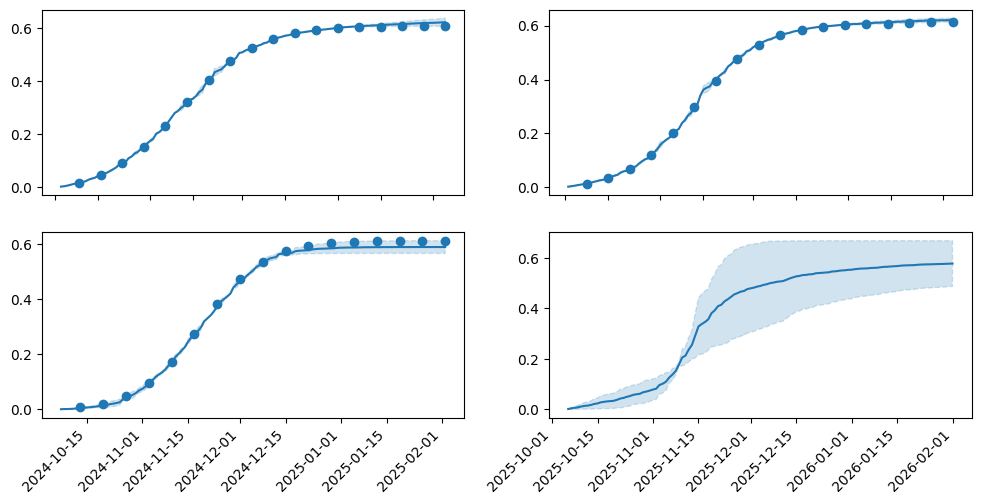

In [13]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(12, 6), ncols=2, nrows=2)

season_to_ax_map = {
    "2022/23": ax1,
    "2023/24": ax2,
    "2024/25": ax3,
    "2025/26": ax4,
}

for season in ("2022/23", "2023/24", "2024/25", "2025/26"):
    ax = season_to_ax_map[season]
    season_summary = posterior_summary[posterior_summary["season"] == season]
    season_observations = plot_observations[plot_observations["season"] == season]
    if len(season_observations):
        ax.plot(
            season_observations["end_date"]
            + pd.DateOffset(years={"2022/23": -2, "2023/24": -1}.get(season, 0)),
            season_observations["prevalence"],
            marker="o",
            linestyle="",
            label="observed",
            color="tab:blue",
        )
    ax.plot(
        season_summary["date"],
        season_summary["median"],
        color="tab:blue",
        linestyle="-",
    )
    ax.fill_between(
        season_summary["date"],
        season_summary["lower"],
        season_summary["upper"],
        alpha=0.2,
        linestyle="--",
        color="tab:blue",
    )

fig.autofmt_xdate(rotation=45)
plt.show()

## Example Incorporating Age Levels

The data used in this example comes from the CDC NCIRD's National Immunization Survey, which can be obtained [here](https://data.cdc.gov/Flu-Vaccinations/Weekly-Cumulative-Influenza-Vaccination-Coverage-A/2v3t-r3np/about_data).

In [14]:
weekly_coverage = get_ncird_weekly_cumulative_vaccination_coverage()
weekly_coverage

,geographic_level,geographic_name,demographic_level,demographic_name,indicator_label,indicator_category_label,month_week,nd_weekly_estimate,ci_half_width_95pct,n_unweighted,...,influenza_season,legend,indicator_category_label_sort,demographic_level_sort,demographic_name_sort,geographic_sort,season_sort,legend_sort,95_ci_lower,95_ci_upper
0,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely or probably will not get a vaccine,January Week 4,30.8,7.8784,159,...,2023-2024,"2023-2024, Arizona, Overall (18+ years)",4,1,1,14,3,3140101,22.9,38.7
1,State,Arizona,Overall,18+ years,4-level vaccination and intent,Definitely will get a vaccine,January Week 4,6.8,4.1669,159,...,2023-2024,"2023-2024, Arizona, Overall (18+ years)",2,1,1,14,3,3140101,2.6,11.0
2,State,Arizona,Overall,18+ years,4-level vaccination and intent,Probably will get a vaccine or are unsure,January Week 4,22.3,7.6134,159,...,2023-2024,"2023-2024, Arizona, Overall (18+ years)",3,1,1,14,3,3140101,14.7,29.9
3,State,Arizona,Overall,18+ years,4-level vaccination and intent,Received a vaccination,January Week 4,40.1,1.8745,8592,...,2023-2024,"2023-2024, Arizona, Overall (18+ years)",1,1,1,14,3,3140101,38.2,41.9
4,State,Arizona,Overall,18+ years,Up-to-date,Yes,January Week 4,40.1,1.8745,8592,...,2023-2024,"2023-2024, Arizona, Overall (18+ years)",<NA>,1,1,14,3,3140101,38.2,41.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17528,National,National,Age,50-64 years,4-level vaccination and intent,Probably will get a vaccine or are unsure,March Week 5,10.3908,3.4865,3162,...,2023-2024,"2023-2024, National, Age (6 Level): 50-64 years",3,4,6,1,3,3010406,6.9,13.9
17529,National,National,Age,50-64 years,4-level vaccination and intent,Received a vaccination,March Week 5,50.2802,1.0457,112370,...,2023-2024,"2023-2024, National, Age (6 Level): 50-64 years",1,4,6,1,3,3010406,49.2,51.3
17530,National,National,Age,50-64 years,Up-to-date,Yes,March Week 5,50.2802,1.0457,112370,...,2023-2024,"2023-2024, National, Age (6 Level): 50-64 years",<NA>,4,6,1,3,3010406,49.2,51.3
17531,National,National,Age,50-64 years,Up-to-date,Yes,April Week 3,50.9854,1.106,112370,...,2023-2024,"2023-2024, National, Age (6 Level): 50-64 years",<NA>,4,6,1,3,3010406,49.9,52.1


In [15]:
usa_coverage = (
    weekly_coverage[
        (weekly_coverage["geographic_level"] == "National")
        & (weekly_coverage["indicator_label"] == "Up-to-date")
        & (weekly_coverage["indicator_category_label"] == "Yes")
        & (weekly_coverage["demographic_level"] == "Age")
        & (
            weekly_coverage["demographic_name"].isin(
                ["18-49 years", "50-64 years", "65+ years"]
            )
        )
    ][
        [
            "influenza_season",
            "current_season_week_ending",
            "demographic_name",
            "nd_weekly_estimate",
        ]
    ]
    .rename(
        columns={
            "influenza_season": "season",
            "current_season_week_ending": "end_date",
            "demographic_name": "age_group",
            "nd_weekly_estimate": "prevalence",
        }
    )
    .sort_values(["season", "age_group", "end_date"])
    .reset_index(drop=True)
    .drop_duplicates()
)
usa_coverage = usa_coverage[
    (usa_coverage["end_date"].dt.month < 2)
    | (usa_coverage["end_date"].dt.month > 7)
    | (
        (usa_coverage["end_date"].dt.month == 2)
        & (usa_coverage["end_date"].dt.day < 11)
    )
]
usa_coverage["end_date"] = usa_coverage["end_date"].dt.normalize()
usa_coverage["plot_end_date"] = usa_coverage["end_date"].copy()
usa_coverage_recombine = []
for (season, _), season_age_coverage in usa_coverage.groupby(["season", "age_group"]):
    if year_shift := {"2021-2022": -2, "2022-2023": -1}.get(season):
        season_age_coverage["end_date"] = season_age_coverage[
            "end_date"
        ] + pd.DateOffset(years=year_shift)
    fill_value = pd.Timestamp(
        year=season_age_coverage["end_date"].min().year, month=9, day=1
    )
    season_age_coverage["start_date"] = season_age_coverage["end_date"].shift(
        1, fill_value=fill_value
    )
    season_age_coverage["prevalence"] = season_age_coverage["prevalence"].cummax()
    season_age_coverage["incidence"] = season_age_coverage[
        "prevalence"
    ] - season_age_coverage["prevalence"].shift(1, fill_value=0)
    usa_coverage_recombine.append(season_age_coverage)
usa_coverage = pd.concat(usa_coverage_recombine, ignore_index=True)
usa_coverage = usa_coverage[
    [
        "season",
        "start_date",
        "end_date",
        "age_group",
        "prevalence",
        "incidence",
        "plot_end_date",
    ]
]
usa_coverage["prevalence"] = 0.01 * usa_coverage["prevalence"]
usa_coverage["incidence"] = 0.01 * usa_coverage["incidence"]

In [16]:
usa_coverage

,season,start_date,end_date,age_group,prevalence,incidence,plot_end_date
0,2021-2022,2021-09-01,2021-10-14,18-49 years,0.17,0.17,2023-10-14
1,2021-2022,2021-10-14,2021-11-11,18-49 years,0.279,0.109,2023-11-11
2,2021-2022,2021-11-11,2021-12-16,18-49 years,0.322,0.043,2023-12-16
3,2021-2022,2021-12-16,2022-01-13,18-49 years,0.346,0.024,2024-01-13
4,2021-2022,2022-01-13,2022-02-10,18-49 years,0.35,0.004,2024-02-10
...,...,...,...,...,...,...,...
105,2023-2024,2024-01-06,2024-01-13,65+ years,0.681,0.003,2024-01-13
106,2023-2024,2024-01-13,2024-01-20,65+ years,0.688,0.007,2024-01-20
107,2023-2024,2024-01-20,2024-01-27,65+ years,0.692,0.004,2024-01-27
108,2023-2024,2024-01-27,2024-02-03,65+ years,0.698,0.006,2024-02-03


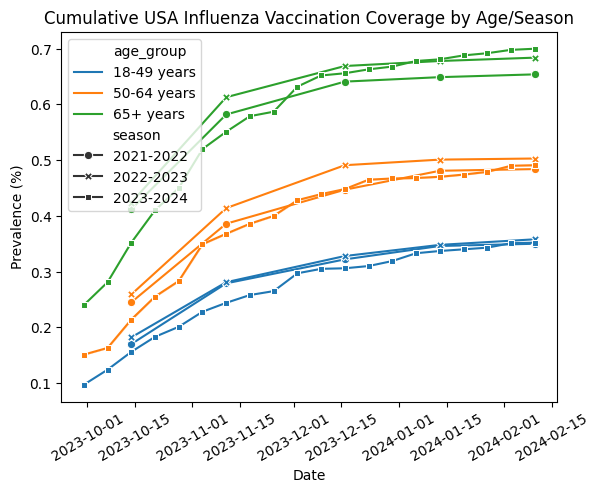

In [17]:
sns.lineplot(
    data=usa_coverage,
    x="plot_end_date",
    y="prevalence",
    hue="age_group",
    style="season",
    markers=True,
    dashes=False,
)
plt.xlabel("Date")
plt.ylabel("Prevalence (%)")
plt.title("Cumulative USA Influenza Vaccination Coverage by Age/Season")
plt.xticks(rotation=30)
plt.show()

In [18]:
seasons = [
    SeasonRange(
        season="2021-2022", start_date=date(2021, 9, 1), end_date=date(2022, 2, 10)
    ),
    SeasonRange(
        season="2022-2023", start_date=date(2022, 9, 1), end_date=date(2023, 2, 10)
    ),
    SeasonRange(
        season="2023-2024", start_date=date(2023, 9, 1), end_date=date(2024, 2, 10)
    ),
]
seasons

[SeasonRange(season='2021-2022', start_date=datetime.date(2021, 9, 1), end_date=datetime.date(2022, 2, 10)),
 SeasonRange(season='2022-2023', start_date=datetime.date(2022, 9, 1), end_date=datetime.date(2023, 2, 10)),
 SeasonRange(season='2023-2024', start_date=datetime.date(2023, 9, 1), end_date=datetime.date(2024, 2, 10))]

In [19]:
age_covariate = CovariateCategories(
    covariate="age_group", categories=("18-49 years", "50-64 years", "65+ years")
)
age_covariate

CovariateCategories(covariate='age_group', categories=('18-49 years', '50-64 years', '65+ years'))

In [28]:
covariates = [
    # Seasonal effects
    PooledCovariate(
        parameter="m",
        covariate=None,
        distribution="Normal",
        distribution_kwargs={
            "mu": logit(0.35),
            "sigma": 0.35,
        },
    ),
    PooledCovariate(
        parameter="r",
        covariate=None,
        distribution="Normal",
        distribution_kwargs={
            "mu": -3.0,
            "sigma": 0.5,
        },
    ),
    PooledCovariate(
        parameter="s",
        covariate=None,
        distribution="Normal",
        distribution_kwargs={
            "mu": 45.0,
            "sigma": 10.0,
        },
    ),
    # Age specific effect
    GaussianCovariate(
        parameter="m",
        covariate="age_group",
        mu=[logit(0.5) - logit(0.3), logit(0.7) - logit(0.3)],
        sigma=2 * [0.2],
    ),
    GaussianCovariate(
        parameter="s",
        covariate="age_group",
        mu=2 * [0.0],
        sigma=2 * [2.5],
    ),
]
covariates

[PooledCovariate(parameter='m', covariate=None, distribution='Normal', distribution_kwargs={'mu': -0.6190392084062235, 'sigma': 0.35}),
 PooledCovariate(parameter='r', covariate=None, distribution='Normal', distribution_kwargs={'mu': -3.0, 'sigma': 0.5}),
 PooledCovariate(parameter='s', covariate=None, distribution='Normal', distribution_kwargs={'mu': 45.0, 'sigma': 10.0}),
 GaussianCovariate(parameter='m', covariate='age_group', mu=[0.8472978603872037, 1.6945957207744071], sigma=[0.2, 0.2], eta=1.0),
 GaussianCovariate(parameter='s', covariate='age_group', mu=[0.0, 0.0], sigma=[2.5, 2.5], eta=1.0)]

In [29]:
observations = usa_coverage[
    ["season", "start_date", "end_date", "age_group", "incidence"]
].rename(columns={"incidence": "value"})
observations["type"] = "incidence"
observations = observations[
    ["season", "start_date", "end_date", "age_group", "type", "value"]
]
observations

,season,start_date,end_date,age_group,type,value
0,2021-2022,2021-09-01,2021-10-14,18-49 years,incidence,0.17
1,2021-2022,2021-10-14,2021-11-11,18-49 years,incidence,0.109
2,2021-2022,2021-11-11,2021-12-16,18-49 years,incidence,0.043
3,2021-2022,2021-12-16,2022-01-13,18-49 years,incidence,0.024
4,2021-2022,2022-01-13,2022-02-10,18-49 years,incidence,0.004
...,...,...,...,...,...,...
105,2023-2024,2024-01-06,2024-01-13,65+ years,incidence,0.003
106,2023-2024,2024-01-13,2024-01-20,65+ years,incidence,0.007
107,2023-2024,2024-01-20,2024-01-27,65+ years,incidence,0.004
108,2023-2024,2024-01-27,2024-02-03,65+ years,incidence,0.006


In [30]:
model = SeasonalUptakeModel(
    logistic_curve,
    covariates,
    observations=observations,
    covariate_categories=[age_covariate],
    season_ranges=seasons,
)
model.build()

In [31]:
model.sample(
    chains=4,
    draws=1000,
    tune=6000,
    random_seed=456,
    target_accept=0.95,
)

Running window adaptation


/Users/twillard/Desktop/GitHub/ACCIDDA/vaxflux/.venv/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: divide by zero encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [32]:
posterior = model.dataframe()
posterior.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5868000 entries, 0 to 651999
Data columns (total 7 columns):
 #   Column     Dtype         
---  ------     -----         
 0   draw       int64         
 1   chain      int64         
 2   season     string        
 3   date       datetime64[ns]
 4   age_group  string        
 5   type       string        
 6   value      float64       
dtypes: datetime64[ns](1), float64(1), int64(2), string(3)
memory usage: 358.2 MB


In [33]:
posterior = (
    posterior[["draw", "chain", "season", "age_group", "date", "value"]]
    .rename(columns={"value": "incidence"})
    .sort_values(["draw", "chain", "season", "age_group", "date"])
    .reset_index(drop=True)
)
posterior["prevalence"] = posterior.groupby(["draw", "chain", "season", "age_group"])[
    "incidence"
].cumsum()
posterior.head(n=10)

,draw,chain,season,age_group,date,incidence,prevalence
0,0,0,2021-2022,18-49 years,2021-09-01,0.000938,0.000938
1,0,0,2021-2022,18-49 years,2021-09-02,0.000376,0.001314
2,0,0,2021-2022,18-49 years,2021-09-03,0.001366,0.002680
3,0,0,2021-2022,18-49 years,2021-09-04,0.000466,0.003146
4,0,0,2021-2022,18-49 years,2021-09-05,0.000558,0.003704
5,0,0,2021-2022,18-49 years,2021-09-06,0.002340,0.006044
6,0,0,2021-2022,18-49 years,2021-09-07,0.000392,0.006435
7,0,0,2021-2022,18-49 years,2021-09-08,0.000880,0.007315
8,0,0,2021-2022,18-49 years,2021-09-09,0.000664,0.007979
9,0,0,2021-2022,18-49 years,2021-09-10,0.001105,0.009084


In [34]:
posterior_summary = (
    posterior[["season", "age_group", "date", "prevalence"]]
    .groupby(["season", "age_group", "date"])
    .agg([lambda x: np.quantile(x, 0.025), "median", lambda x: np.quantile(x, 0.975)])
    .reset_index()
)
posterior_summary.columns = ["season", "age_group", "date", "lower", "median", "upper"]
posterior_summary.head(n=10)

,season,age_group,date,lower,median,upper
0,2021-2022,18-49 years,2021-09-01,0.000315,0.000726,0.003365
1,2021-2022,18-49 years,2021-09-02,0.000557,0.001802,0.005609
2,2021-2022,18-49 years,2021-09-03,0.000668,0.003319,0.008911
3,2021-2022,18-49 years,2021-09-04,0.000981,0.004202,0.010152
4,2021-2022,18-49 years,2021-09-05,0.001666,0.005835,0.013465
5,2021-2022,18-49 years,2021-09-06,0.001934,0.008905,0.021670
6,2021-2022,18-49 years,2021-09-07,0.002127,0.010597,0.027291
7,2021-2022,18-49 years,2021-09-08,0.002891,0.011679,0.035898
8,2021-2022,18-49 years,2021-09-09,0.003343,0.012371,0.038935
9,2021-2022,18-49 years,2021-09-10,0.003581,0.013753,0.041179


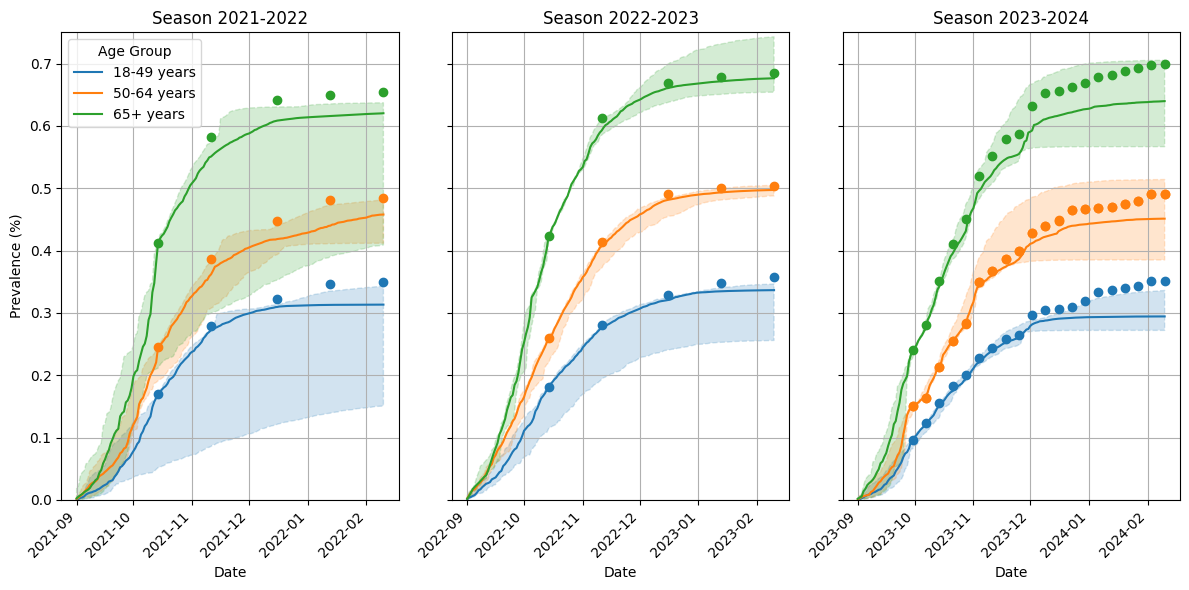

In [ ]:
fig, axes = plt.subplots(
    figsize=(12, 6),
    ncols=3,
    sharey=True,
)

season_to_ax_map = dict(
    zip(("2021-2022", "2022-2023", "2023-2024"), axes, strict=False)
)
age_group_to_color_map = {
    "18-49 years": "tab:blue",
    "50-64 years": "tab:orange",
    "65+ years": "tab:green",
}

for season, age_group in product(
    season_to_ax_map.keys(), age_group_to_color_map.keys()
):
    ax = season_to_ax_map[season]
    color = age_group_to_color_map[age_group]
    season_summary = posterior_summary[
        (posterior_summary["season"] == season)
        & (posterior_summary["age_group"] == age_group)
    ]
    season_observations = usa_coverage[
        (usa_coverage["season"] == season) & (usa_coverage["age_group"] == age_group)
    ]
    if len(season_summary):
        ax.plot(
            season_summary["date"],
            season_summary["median"],
            color=color,
            linestyle="-",
            label=age_group,
        )
        ax.fill_between(
            season_summary["date"],
            season_summary["lower"],
            season_summary["upper"],
            alpha=0.2,
            linestyle="--",
            color=color,
        )
    if len(season_observations):
        ax.plot(
            season_observations["end_date"],
            season_observations["prevalence"],
            marker="o",
            linestyle="",
            color=color,
        )

for season, ax in season_to_ax_map.items():
    ax.set_title(f"Season {season}")
    ax.set_xlabel("Date")
    if season == "2021-2022":
        ax.set_ylabel("Prevalence (%)")
        ax.legend(title="Age Group", loc="upper left")
    ax.grid(visible=True)
    ax.set_ylim((0.0, 0.75))

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
plt.show()